The purpose of this notebook is to demonstrate how to do a single refinement with the pySULI library modules.



# General imports

In [45]:
import sys

sys.path += ['../src']

In [47]:
# We need to import some Python libraries here first.

import gsas2_functions as rf
import os
import xarray as xr
import numpy as np
import random
import string
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

try:
    %matplotlib widget
except:
    %matplotlib inline

In [49]:
# We need import pyFAI,PyQt5,ipympl packages (if not available pip-install)


try:
    import ipympl
except:
    !! pip install ipympl

# if running on google colab
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass

# Setting up the example data path

In [52]:
# We assume this notebook and its data is on Google Drive so that we can use Google Colab.
# Otherwise, replace example_data_path with the path the notebook and its data folder are stored on

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/SULI-2024/repositories/pySULI/notebooks/')
    from google.colab import output
    output.enable_custom_widget_manager()

except:
    pass

In [58]:
# Assuming notebook and data folder are here.

here = os.getcwd()
example_data_path = 'example_data/xrd_refinement_with_gsas2/'

os.chdir('%s/%s'%(here,example_data_path))
os.listdir()

['gsas.instprm',
 'Ceo2.cif',
 '.DS_Store',
 'gsas2_scratch',
 'Pt.cif',
 'ZrH.bak0.gpx',
 'ZrH.bak1.gpx',
 'ZrH.bak3.gpx',
 'ZrH.bak2.gpx',
 'Zr.cif',
 'Pt.gpx',
 'ZrH.bak4.gpx',
 'LaB6.nc',
 'ZrH.lst',
 'LaB6.cif',
 '.gsas2_scratch',
 '.ipynb_checkpoints',
 'ZrH.nc',
 'Zr-H1.66.cif',
 'Background.nc',
 'ZrH.gpx',
 'Pt.nc',
 'LaB6.gpx']

In [60]:
ls

Background.nc  LaB6.nc        Zr-H1.66.cif   ZrH.bak2.gpx   ZrH.lst
Ceo2.cif       Pt.cif         Zr.cif         ZrH.bak3.gpx   ZrH.nc
LaB6.cif       Pt.gpx         ZrH.bak0.gpx   ZrH.bak4.gpx   gsas.instprm
LaB6.gpx       Pt.nc          ZrH.bak1.gpx   ZrH.gpx        gsas2_scratch/


# Setting up GSAS-II package and custom refinement functions

In [63]:
# assuming GSAS-II is installed on the machine on conda
# as explained here: https://advancedphotonsource.github.io/GSAS-II-tutorials/install.html
# as a result of "conda create -n GSASII briantoby::gsas2pkg  -c conda-forge", GSAS-II
# will be installed on a eng location. Then we add it to path as below.

import sys

user = "kmorell"

match user:
    case "mtopsakal":
        sys.path += ['/home/mt/software/miniforge3/envs/GSASII/GSAS-II/GSASII']
    case "pmeshkov":
        sys.path += ['/opt/anaconda3/envs/GSASII/GSAS-II/GSASII']
    case "kmorell":
        sys.path += ['/Users/kevinmorell/g2full/GSAS-II/GSASII']

# we then import GSASIIscriptable
import GSASIIscriptable as G2sc
import pybaselines # this comes with gsas2_package

from IPython.display import clear_output

# clear_output()

## GSAS functions in pySULI

All of the GSAS-II functions defined in notebook 005 are contained within the pySULI modules GSAS2_functions and functions_lib_version


# Refinements

In [68]:
#Defining the background
with xr.open_dataset('Background.nc') as ds:
    da_input_bkg = ds.i2d.mean(dim='azimuthal')

In [70]:
#Creating the refiner
first_refiner = rf.Refiner(
    nc_path = 'LaB6.nc',
    phases = [{'cif_abs_path':'LaB6.cif','phase_name':'LaB6','scale':1},],
    gsas2_scratch = None,
    instrument_parameters_file = 'gsas.instprm',
    q_range = None,
    da_input_bkg = None 
#NOTE: Refiner can create its own background if set to None. Try both to see changes in GoF and Rwp
)

/Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1721913721.53_AS0NZPE.tmp/data.xy read by Reader comma/tab/semicolon separated
Instrument parameters read: /Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/gsas.instprm (G2 fmt) bank None
/Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/LaB6.cif read by Reader CIF
gpx file saved as /Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1721913721.53_AS0NZPE.tmp/gsas.gpx
gpx file saved as /Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1721913721.53_AS0NZPE.tmp/gsas.gpx


gpx file saved as /Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1721913721.53_AS0NZPE.tmp/gsas.gpx
gpx file saved as /Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1721913721.53_AS0NZPE.tmp/gsas.gpx
gpx file saved as /Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1721913721.53_AS0NZPE.tmp/gsas.gpx
gpx file saved as /Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1721913721.53_AS0NZPE.tmp/gsas.gpx
gpx file saved as /Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1721913721.53_AS0NZPE.tmp/gsas.gpx
gpx file saved as /Users/kevinmorell/repositories/pySULI-1/notebooks/example_data/xrd_refinement_with_gsas2/.gsas2_scratch/1721913721.53_AS0NZPE.tmp/gsas.gpx
gpx file saved as /Users/kevinmorell/repositories/py

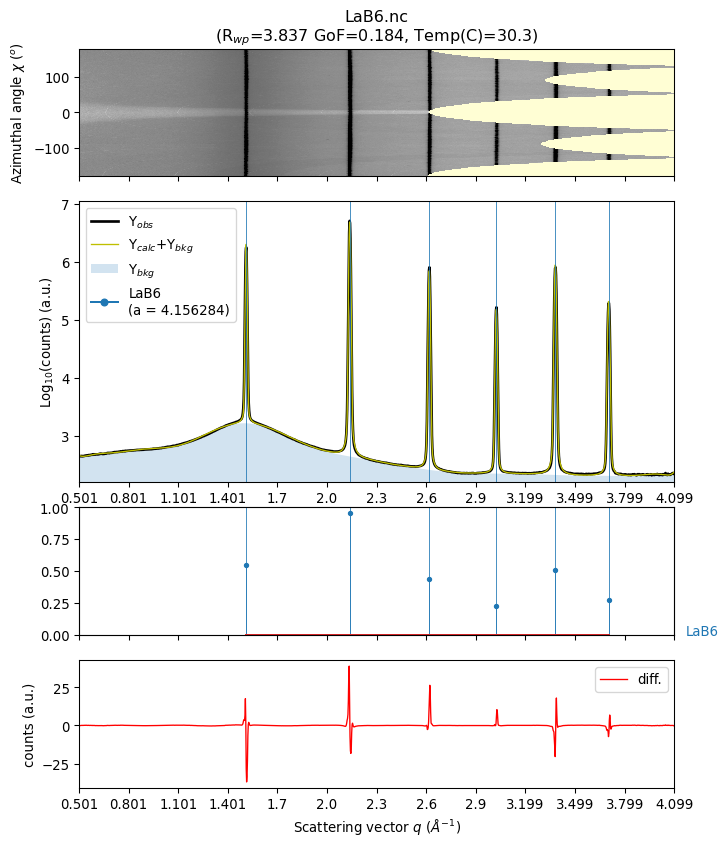

In [78]:
# with pySULI, the 'refinement recipe' has been replaced with functions
first_refiner.refine_background(20)
first_refiner.refine_cell_params()
first_refiner.refine_strain_broadening()
first_refiner.refine_size_broadening()
first_refiner.refine_background(20)
first_refiner.refine_inst_parameters()
first_refiner.save_refinement()
first_refiner.plot_refinement_results()